## Imports

In [2]:
import csv
import cv2
import os
import numpy as np
import random
from random import shuffle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## Keras imports

In [3]:
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten, Cropping2D, Lambda, Dropout

## Path

In [4]:
DATA_PATH = "data/driving_log.csv"
DATA_IMG = "data/"

## Get data

In [5]:
# Open csv
with open(DATA_PATH, "r") as f:
    content = [line for line in csv.reader(f)]
# Split in train/validation set
random_indexs = np.array(range(len(content)))
train_index, valid_index = train_test_split(random_indexs, test_size=0.15)

print("Training size = %s" % len(train_index))
print("Validation size = %s" % len(valid_index))

Training size = 6831
Validation size = 1206


In [6]:
def get_data(log_content, index_list, batch_size):
    """
        Return Data from the simulator
        **input:
            *log_content (2dim Array) Data from the log file
            *index_list: Indexes to used to create each batch
            *batch_size (Int) Size of each batch
    """
    images, rotations = [], []
    while True:
        for index in index_list:
            # Angle correction
            angle_correction = [0., 0.25, -.25]
            # Randomly select one of the three images
            i = random.choice([0, 1, 2]) # [Center, Left, Right]
            img = cv2.imread(os.path.join(DATA_IMG, log_content[index][i]).replace(" ", ""))
            if img is None: continue
            # Convert image color
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            # Get the rotation
            rotation = float(log_content[index][3])
            # Apply correction
            rotation = rotation + angle_correction[i]

            # Data augmentation:
            # 1/2: random roation of the image
            if random.random() > 0.5:
                img = cv2.flip(img, 1)
                rotation = rotation * -1

            # Append the new image/rotation to the current batch
            images.append(img)
            rotations.append(rotation)
            # Yield the new batch
            if len(images) >= batch_size:
                yield np.array(images), np.array(rotations)
                images, rotations = [], []

-0.25


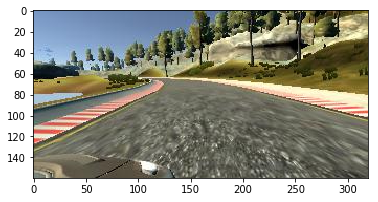

In [7]:
images, rotations = next(get_data(content, train_index, 64))
plt.imshow(images[20])
print(rotations[20])

# Create the keras model

In [8]:
model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1., input_shape = (160, 320, 3)))
model.add(Cropping2D(cropping=((70, 25), (0, 0)), input_shape = (160, 320, 3)))
model.add(Conv2D(8, 9, strides=(4, 4), padding="same", activation="elu"))
model.add(Conv2D(16, 5, strides=(2, 2), padding="same", activation="elu"))
model.add(Conv2D(32, 4, strides=(1, 1), padding="same", activation="elu"))
model.add(Flatten())
model.add(Dropout(.6))
model.add(Dense(1024, activation="elu"))
model.add(Dropout(.3))
model.add(Dense(1))
model.compile(loss="mse", optimizer="adam")

In [9]:
BATCH_SIZE = 64

model.fit_generator(
    generator=get_data(content, train_index, BATCH_SIZE),
    steps_per_epoch=len(train_index) / BATCH_SIZE,
    validation_data=get_data(content, valid_index, BATCH_SIZE),
    validation_steps=len(valid_index) / BATCH_SIZE,
    epochs=1)

model.save("model.h5")

Epoch 1/1
 178/5336 [>.............................] - ETA: 31:44 - loss: 0.3574

KeyboardInterrupt: 